In [1]:
import numpy as np

In [2]:
from keras.utils import to_categorical

Using TensorFlow backend.


In [4]:
def load_npy(prefix):
    xs = np.load("./svhn/{}_preprocessed_img.npy".format(prefix))
    labels = np.load("./svhn/{}_preprocessed_labels.npy".format(prefix))
    # RGB => Grayscale
    xs = np.dot(xs, [0.299, 0.587, 0.114]).reshape(xs.shape[0], 32, 32, 1) * 1./255
    # getting length only for now
    digits_len = to_categorical( np.array(list(map(len, labels)) , dtype=np.int), num_classes=7 )
    padded_labels = np.array(list(map(lambda x: list("{:0>6}".format(x)), labels) ) ).astype(np.int)
    digits = to_categorical(padded_labels).reshape(-1, 6, 10) # 6 digits, 10 classes
    #padded_labels = list(map(lambda x: list("{:0>6}".format(x))[-1], labels) ) 
    #last_digit = to_categorical( padded_labels,num_classes=10)
    return xs, [digits_len,] + [ digits[:, i, :] for i in range(6)]
    
def load_data():
    x_train, y_train = load_npy("train")
    x_test, y_test = load_npy("test")
    return x_train, y_train, x_test, y_test


In [5]:
x_train, y_train, x_test, y_test = load_data()

In [6]:
from keras.preprocessing.image import array_to_img

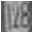

In [7]:
array_to_img(x_train[8])

In [8]:
np.argmax(y_train[0][8]), [np.argmax(y_train[i+1][8]) for i in range(6)]

(3, [0, 0, 0, 1, 2, 8])

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Reshape, LocallyConnected2D, Input, ZeroPadding2D


In [11]:
def build_lnn(model, i):
    lnn = ZeroPadding2D(padding=(1, 1))(model)
    lnn = LocallyConnected2D(64, (3, 3))(lnn)
    lnn = Activation('relu')(lnn)

    lnn = ZeroPadding2D(padding=(1, 1))(lnn)
    lnn = LocallyConnected2D(32, (3, 3))(lnn)
    lnn = Activation('relu')(lnn)

    lnn = Flatten()(lnn)
    lnn = Dropout(0.5)(lnn)
    #lnn = Dense(10)(lnn)
    #lnn = Activation('softmax', name="Digit_Last_Smax_{}".format(i))(lnn)
    return lnn

In [12]:
img_input = Input(shape=(32,32,1))

cnn = Sequential()
cnn.add(Conv2D(16, (3, 3), input_shape=(32, 32, 1)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(32, (3, 3)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(64, (3, 3)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

#cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
#cnn.add(Dense(1024))
#cnn.add(Activation('relu'))
#cnn.add(Dropout(0.5))
cnn = cnn(img_input)

In [13]:
size = Flatten()(cnn)
size = Dense(1024)(size)
size = Activation('relu') (size)
size = Dropout(0.5) (size)
size = Dense(7)(size)
size = Activation('softmax', name="Length_Smax")(size)

In [16]:
lnn = build_lnn(cnn, 0)

digits = []

for i in range(6):
    d = Dense(10)(lnn)
    d = Activation('softmax', name="Digit_Last_Smax_{}".format(i))(d)
    digits.append(d)


In [17]:
from keras.models import Model

In [18]:
model = Model(inputs=img_input, outputs=[size,] + digits)

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 2, 2, 64)      23296                                        
____________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D) (None, 4, 4, 64)      0                                            
____________________________________________________________________________________________________
locally_connected2d_3 (LocallyCo (None, 2, 2, 64)      147712                                       
___________________________________________________________________________________________

In [ ]:
model.fit(x_train, y_train, validation_split=0.2, epochs=5)

Train on 26721 samples, validate on 6681 samples
Epoch 1/5
26721/26721 [==============================] - 29s - loss: 6.6833 - Length_Smax_loss: 0.8308 - Digit_Last_Smax_0_loss: 0.0271 - Digit_Last_Smax_1_loss: 0.0271 - Digit_Last_Smax_2_loss: 0.2285 - Digit_Last_Smax_3_loss: 1.0334 - Digit_Last_Smax_4_loss: 2.1791 - Digit_Last_Smax_5_loss: 2.3574 - Length_Smax_acc: 0.6519 - Digit_Last_Smax_0_acc: 0.9991 - Digit_Last_Smax_1_acc: 0.9989 - Digit_Last_Smax_2_acc: 0.9557 - Digit_Last_Smax_3_acc: 0.6993 - Digit_Last_Smax_4_acc: 0.2050 - Digit_Last_Smax_5_acc: 0.1128 - val_loss: 5.9760 - val_Length_Smax_loss: 0.4757 - val_Digit_Last_Smax_0_loss: 0.0042 - val_Digit_Last_Smax_1_loss: 0.0056 - val_Digit_Last_Smax_2_loss: 0.2159 - val_Digit_Last_Smax_3_loss: 0.9760 - val_Digit_Last_Smax_4_loss: 2.0280 - val_Digit_Last_Smax_5_loss: 2.2706 - val_Length_Smax_acc: 0.8072 - val_Digit_Last_Smax_0_acc: 0.9999 - val_Digit_Last_Smax_1_acc: 0.9997 - val_Digit_Last_Smax_2_acc: 0.9542 - val_Digit_Last_Smax_

In [21]:
model.evaluate(x_test, y_test)

12960/13068 [============================>.] - ETA: 0s

[3.7786481097308657,
 0.22941472099476501,
 5.7159059915009056e-05,
 0.001609885009308113,
 0.1337030399520176,
 0.57262270759653167,
 1.2601975432440597,
 1.5810430537388163,
 0.92118151210884747,
 1.0,
 0.99984695439240889,
 0.9559228650137741,
 0.82300275483918106,
 0.56251913069182669,
 0.42837465566562738]

In [23]:
model.metrics_names

['loss',
 'Length_Smax_loss',
 'Digit_Last_Smax_0_loss',
 'Digit_Last_Smax_1_loss',
 'Digit_Last_Smax_2_loss',
 'Digit_Last_Smax_3_loss',
 'Digit_Last_Smax_4_loss',
 'Digit_Last_Smax_5_loss',
 'Length_Smax_acc',
 'Digit_Last_Smax_0_acc',
 'Digit_Last_Smax_1_acc',
 'Digit_Last_Smax_2_acc',
 'Digit_Last_Smax_3_acc',
 'Digit_Last_Smax_4_acc',
 'Digit_Last_Smax_5_acc']

In [ ]:
from IPython.display import display

Predicted  2 [0, 0, 0, 0, 2, 4]
Actual     2 [0, 0, 0, 0, 2, 4]


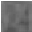

Predicted  2 [0, 0, 0, 0, 2, 2]
Actual     2 [0, 0, 0, 0, 2, 7]


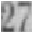

Predicted  2 [0, 0, 0, 0, 9, 7]
Actual     2 [0, 0, 0, 0, 8, 2]


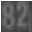

Predicted  2 [0, 0, 0, 0, 3, 1]
Actual     2 [0, 0, 0, 0, 6, 1]


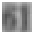

Predicted  2 [0, 0, 0, 0, 2, 2]
Actual     2 [0, 0, 0, 0, 2, 5]


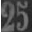

In [62]:
samples = np.random.choice(x_test.shape[0], 5)
y_pred = model.predict(x_test[samples])

for s,sample in enumerate(samples):
    print( "Predicted ",np.argmax( y_pred[0][s] ), [np.argmax(y_pred[i+1][s]) for i in range(6)])
    print( "Actual    ", np.argmax( y_test[0][sample] ), [np.argmax(y_test[i+1][sample]) for i in range(6)])
    display(array_to_img(x_test[sample]))

In [63]:
model.save("./svhn/model_20170803.h5")